# Agent

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [1]:
%pip install -q -U langchain_openai langchain_core langgraph

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dotenv import load_dotenv

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

dotenv_path = os.path.join(parent_dir, ".env")
load_dotenv(dotenv_path)

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["OPENAPI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI


vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

llm = ChatOpenAI(model="gpt-4o")

def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [5]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    # The input document
    input_file:  Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


# This is now the agent
# We can see from the invocation that the agent invokes the LLM with the tools gets invoked
# with the system message and the user message.
# Every time this assistant (agent) is called, it will invoke the LLM with the tools, system message, and user message.
# Effectively, using the ReAct agent pattern.

def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computation without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")


    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],"input_file":state["input_file"]}

We define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

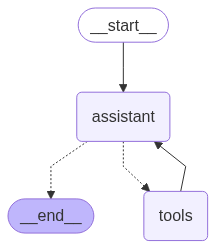

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "assistant")

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages,"input_file":None})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_s0G5ewtIQyHUCOv0fClsCpgh)
 Call ID: call_s0G5ewtIQyHUCOv0fClsCpgh
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner leaft in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [9]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]

messages = react_graph.invoke({"messages": messages,"input_file":"Batman_training_and_meals.png"})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_2KlHAqYm9nm8Iia4aJB6vdIN)
 Call ID: call_2KlHAqYm9nm8Iia4aJB6vdIN
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING 
clean and jerk lifts—3 reps/8 sets. 262 lbs. 
5 sets metabolic conditioning:
2 mile run
12 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes gymnastics (work on muscle ups in particular)
high bar